In [1]:
import pandas as pd
import scipy.io
import numpy as np

In [2]:
data = scipy.io.loadmat("dados_identificacao_ruido_gaussiano.mat")
x = data["x"][0]                                # amostras do processo de entrda x(n)
d = data["d"][0]                                # observações da saída do sistema

##### Questão 1:

##### a) Solução de Wiener para o filtro FIR com $M = 2$ coeficientes:

In [3]:
def manual_autocorrelation(x, lag):
    n = len(x)
    mean_x = np.mean(x)
    if lag == 0:
        cov = np.sum((x) * (x)) / (n - lag)
    else:
        cov = np.sum((x[:-lag]) * (x[lag:])) / (n - lag)
    return cov 

def autocorrelation_matrix(x, max_lag):
    autocorr_matrix = np.zeros((max_lag + 1, max_lag + 1))
    for i in range(max_lag + 1):
        for j in range(max_lag + 1):
            lag = abs(i - j)
            autocorr_matrix[i, j] = manual_autocorrelation(x, lag)
    return autocorr_matrix

def compute_cross_correlation(x, d, M):
    N = len(d)
    p = np.zeros(M)
    for k in range(M):
        p[k] = np.sum(d[k:N] * x[0:N-k]) / (N)
    return p

def wiener_filter_output(x, w):
    N = len(x)
    M = len(w)
    d_hat = np.zeros(N)
    for n in range(M-1, N):
        x_time = x[n - M + 1: n + 1][::-1]
        d_hat[n] = np.dot(w, x_time) 
    return d_hat[M-1:]

r = autocorrelation_matrix(x, 1)
p = compute_cross_correlation(x, d, 2)
w = np.dot(np.linalg.inv(r), p.T)


In [4]:
r = autocorrelation_matrix(x, 1)
p = compute_cross_correlation(x, d, 2)
w = np.dot(np.linalg.inv(r), p.T)

In [5]:
r

array([[0.99777926, 0.05747573],
       [0.05747573, 0.99777926]])

##### Matriz de Autocorrelação:
$$
R_x = \begin{bmatrix}
0.9977 & 0.0574 \\
0.0574 & 0.9977 \\
\end{bmatrix}
$$

##### Vetor de Correlação Cruzada:
$$
\underline{p} = \begin{bmatrix}
1.025 & 0.2853 \\
\end{bmatrix}
$$

##### Coeficientes de Wiener:
$$
\underline{\omega} = \begin{bmatrix}
1.0147 & 0.2274 \\
\end{bmatrix}
$$

##### b) Trajetórias associadas aos três algoritmos (LMS, RLS e Sinal do Erro) sobre as curvas de nível da superfície do erro quadrático médio:

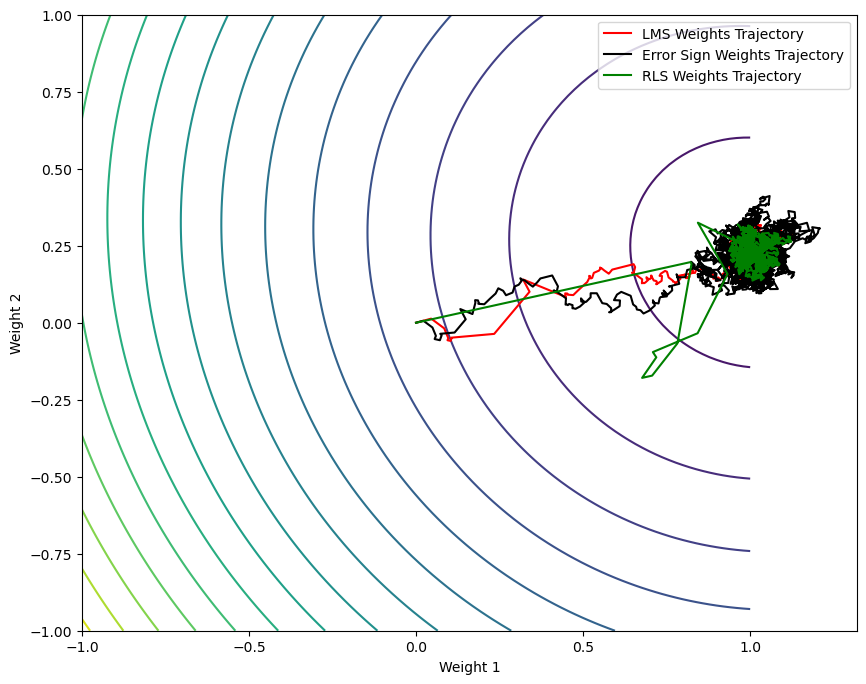

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def generate_path_trajectory(x, p, r, mu_lms, mu_sign, lambda_rls, true_weights, desired_output):
    """
    Simulate and plot the trajectory of LMS, Sign, and RLS algorithms for adaptive filtering.

    Parameters:
        x (array): Input signal.
        p (array): Cross-correlation vector.
        r (array): Autocorrelation matrix.
        mu_lms (float): Step size for LMS algorithm.
        mu_sign (float): Step size for Sign algorithm.
        lambda_rls (float): Forgetting factor for RLS algorithm.
        true_weights (array): True weights (Wiener solution).
        desired_output (array): Desired output signal.

    Returns:
        list: LMS output predictions over time.
        array: LMS weights over time.
    """
    np.random.seed(0)
    T = len(x)  # Number of samples
    
    # Initialize weights and variables
    w_lms = np.zeros((T, 2))
    w_sign = np.zeros((T, 2))
    w_rls = np.zeros((T, 2))
    P = np.linalg.inv(r)  # Inverse correlation matrix for RLS
    
    # Grid for contour plot of Mean Squared Error
    W1, W2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    MSE = np.mean([(desired_output[n] - (W1 * x[n] + W2 * x[n-1])) ** 2 for n in range(1, T)], axis=0)

    lms_predictions = []

    # Run algorithms and track weight trajectories
    for n in range(1, T):
        x_n = np.array([x[n], x[n - 1]])  # Input vector
        
        # LMS Algorithm
        y_lms = np.dot(w_lms[n-1], x_n)
        lms_predictions.append(y_lms)
        e_lms = desired_output[n] - y_lms
        w_lms[n] = w_lms[n-1] + mu_lms * e_lms * x_n
        
        # Sign Algorithm
        y_sign = np.dot(w_sign[n-1], x_n)
        e_sign = desired_output[n] - y_sign
        w_sign[n] = w_sign[n-1] + mu_sign * np.sign(e_sign) * x_n
        
        # RLS Algorithm
        y_rls = np.dot(w_rls[n-1], x_n)
        e_rls = desired_output[n] - y_rls
        k = np.dot(P, x_n) / (lambda_rls + np.dot(x_n, np.dot(P, x_n)))
        w_rls[n] = w_rls[n-1] + k * e_rls
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_rls

    # Plot trajectories
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contour(W1, W2, MSE, levels=15, cmap="viridis")
    ax.plot(w_lms[:, 0], w_lms[:, 1], 'r-', label="LMS Weights Trajectory")
    ax.plot(w_sign[:, 0], w_sign[:, 1], 'black', label="Error Sign Weights Trajectory")
    ax.plot(w_rls[:, 0], w_rls[:, 1], 'g-', label="RLS Weights Trajectory")
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    # ax.set_title("Weight Trajectories and Mean Square Error Contour")
    ax.legend()
    plt.show()

    return lms_predictions, w_lms

# Example usage (replace x, p, r, w, d with your actual data):
y_lms, weights_lms = generate_path_trajectory(x, p, r, 0.012, 0.012, 0.99, w, d)


##### c) Evolução do Erro Quadrático Instantâneo em função do número de iterações $(n = 2000)$:

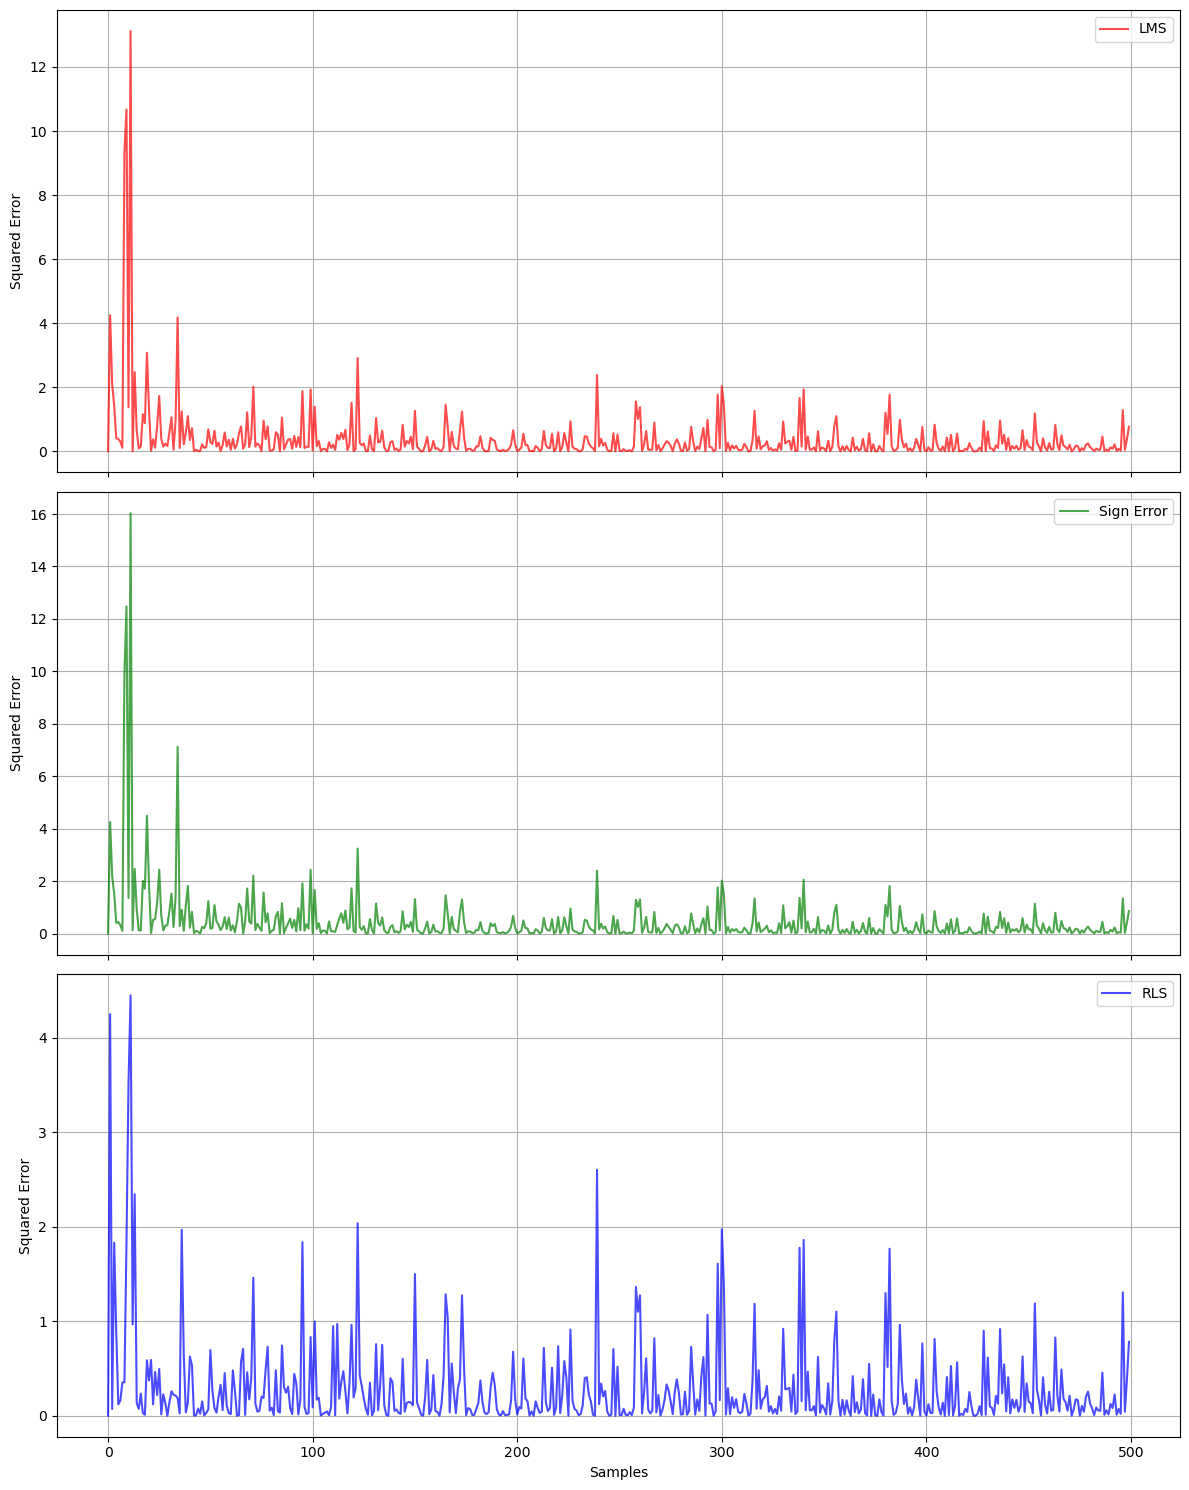

In [7]:
def plot_mean_square_error_subplots(x, d, mu_LMS, mu_sign, lambda_RLS):
    # Configurações e parâmetros
    np.random.seed(0)
    T = len(x)  # Número de amostras

    # Pesos reais do sistema
    true_w = np.array([1.01479344, 0.22749663])  

    # Inicialização de pesos e erro quadrático instantâneo
    w_LMS = np.zeros((T, 2))
    w_sign = np.zeros((T, 2))
    w_RLS = np.zeros((T, 2))
    P = np.eye(2) * 1000  # Matriz inicial para RLS

    eqm_LMS = np.zeros(T)
    eqm_sign = np.zeros(T)
    eqm_RLS = np.zeros(T)

    # Execução dos algoritmos
    for n in range(1, T):
        x_n = np.array([x[n], x[n - 1]])  # Vetor de entrada  

        # LMS
        y_LMS = np.dot(w_LMS[n-1], x_n)
        e_LMS = d[n] - y_LMS
        w_LMS[n] = w_LMS[n-1] + mu_LMS * e_LMS * x_n
        eqm_LMS[n] = e_LMS**2  # Erro quadrático instantâneo para LMS

        # Sinal do erro
        y_sign = np.dot(w_sign[n-1], x_n)
        e_sign = d[n] - y_sign
        w_sign[n] = w_sign[n-1] + mu_sign * np.sign(e_sign) * x_n
        eqm_sign[n] = e_sign**2  # Erro quadrático instantâneo para sinal do erro

        # RLS
        y_RLS = np.dot(w_RLS[n-1], x_n)
        e_RLS = d[n] - y_RLS
        k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
        w_RLS[n] = w_RLS[n-1] + k * e_RLS
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS
        eqm_RLS[n] = e_RLS**2  # Erro quadrático instantâneo para RLS

    # Plotagem dos gráficos
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

    axes[0].plot(eqm_LMS[:500], label="LMS", color="red", alpha=0.7)
    # axes[0].set_title("Erro Quadrático Instantâneo - LMS")
    axes[0].set_ylabel("Squared Error")
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(eqm_sign[:500], label="Sign Error", color="green", alpha=0.7)
    # axes[1].set_title("Squared Error Instantâneo - Sign Error")
    axes[1].set_ylabel("Squared Error")
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(eqm_RLS[:500], label="RLS", color="blue", alpha=0.7)
    # axes[2].set_title("Squared Error Instantâneo - RLS")
    axes[2].set_xlabel("Samples")
    axes[2].set_ylabel("Squared Error")
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout()
    plt.show()

# Exemplo de chamada da função
plot_mean_square_error_subplots(x, d, 0.01, 0.01, 0.99)


##### d) Evolução dos erros dos coeficientes do filtro em função do número de iterações $(n = 2000)$:

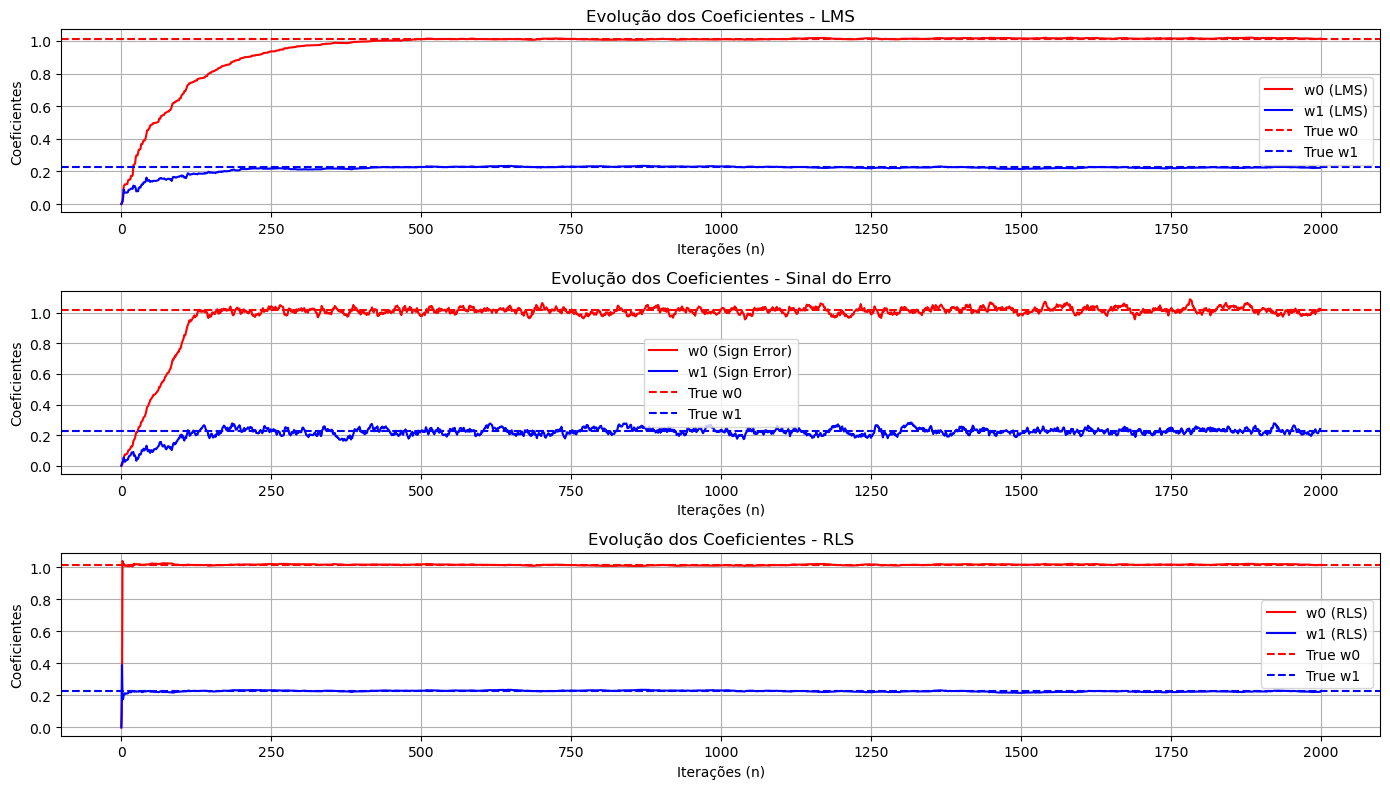

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_weight_filters_coef(x, d, mu_LMS, mu_sign, lambda_RLS):
    # Parameters and setup
    np.random.seed(0)
    T = len(x)  # Number of samples

    # Input signal and unknown system
    x = np.random.randn(T)  # Gaussian white noise
    true_w = np.array([1.01479344, 0.22749663]) # True weights of the system
    d = np.convolve(x, true_w, 'same') + 0.05 * np.random.randn(T)  # Noisy output

    # Initialize weights and RLS matrix
    w_LMS = np.zeros((T, 2))
    w_sign = np.zeros((T, 2))
    w_RLS = np.zeros((T, 2))
    P = np.eye(2) * 1000

    weights_evolution_lms = []
    weights_evolution_rls = []
    weights_evolution_sign = []
    # Compute filter coefficients
    for n in range(1, T):
        x_n = np.array([x[n], x[n - 1]])  # Input vector

        # LMS
        y_LMS = np.dot(w_LMS[n-1], x_n)
        e_LMS = d[n] - y_LMS
        w_LMS[n] = w_LMS[n-1] + mu_LMS * e_LMS * x_n

        # Sign Error
        y_sign = np.dot(w_sign[n-1], x_n)
        e_sign = d[n] - y_sign
        w_sign[n] = w_sign[n-1] + mu_sign * np.sign(e_sign) * x_n

        # RLS
        y_RLS = np.dot(w_RLS[n-1], x_n)
        e_RLS = d[n] - y_RLS
        k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
        w_RLS[n] = w_RLS[n-1] + k * e_RLS
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS
        weights_evolution_lms.append(w_LMS[n])
        weights_evolution_rls.append(w_RLS[n])
        weights_evolution_sign.append(w_sign[n])

    # Plot the evolution of filter coefficients
    plt.figure(figsize=(14, 8))

    # LMS
    plt.subplot(3, 1, 1)
    plt.plot(w_LMS[:, 0], label="w0 (LMS)", color="red")
    plt.plot(w_LMS[:, 1], label="w1 (LMS)", color="blue")
    plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
    plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
    plt.title("Evolução dos Coeficientes - LMS")
    plt.xlabel("Iterações (n)")
    plt.ylabel("Coeficientes")
    plt.legend()
    plt.grid()

    # Sign Error
    plt.subplot(3, 1, 2)
    plt.plot(w_sign[:, 0], label="w0 (Sign Error)", color="red")
    plt.plot(w_sign[:, 1], label="w1 (Sign Error)", color="blue")
    plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
    plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
    plt.title("Evolução dos Coeficientes - Sinal do Erro")
    plt.xlabel("Iterações (n)")
    plt.ylabel("Coeficientes")
    plt.legend()
    plt.grid()

    # RLS
    plt.subplot(3, 1, 3)
    plt.plot(w_RLS[:, 0], label="w0 (RLS)", color="red")
    plt.plot(w_RLS[:, 1], label="w1 (RLS)", color="blue")
    plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
    plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
    plt.title("Evolução dos Coeficientes - RLS")
    plt.xlabel("Iterações (n)")
    plt.ylabel("Coeficientes")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    return w_RLS, true_w, weights_evolution_lms, weights_evolution_rls, weights_evolution_sign

w_rls, true_w, weight_evolution_lms, weight_evolution_rls, weight_evolution_sign = plot_weight_filters_coef(x, d, 0.01, 0.01, 0.99)


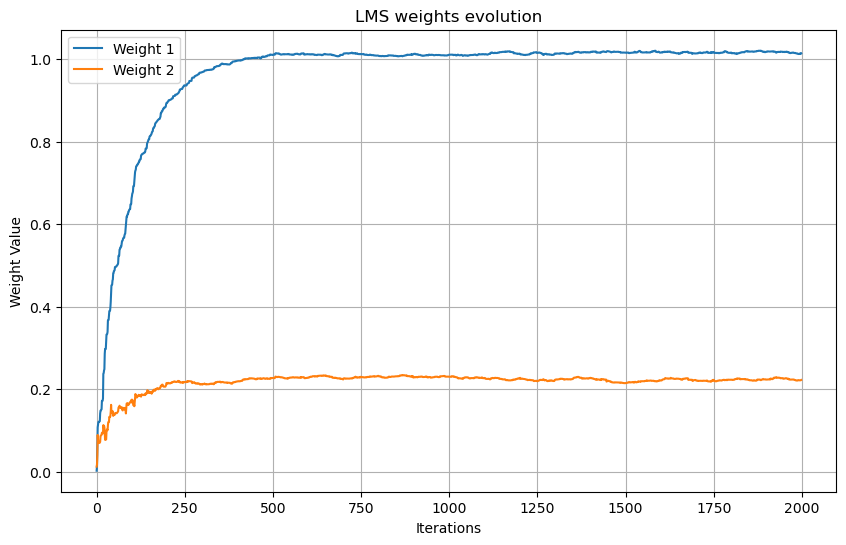

In [12]:
from my_functions import lms, plot_weights_evolution

plot_weights_evolution(weight_evolution_lms, title="LMS weights evolution")

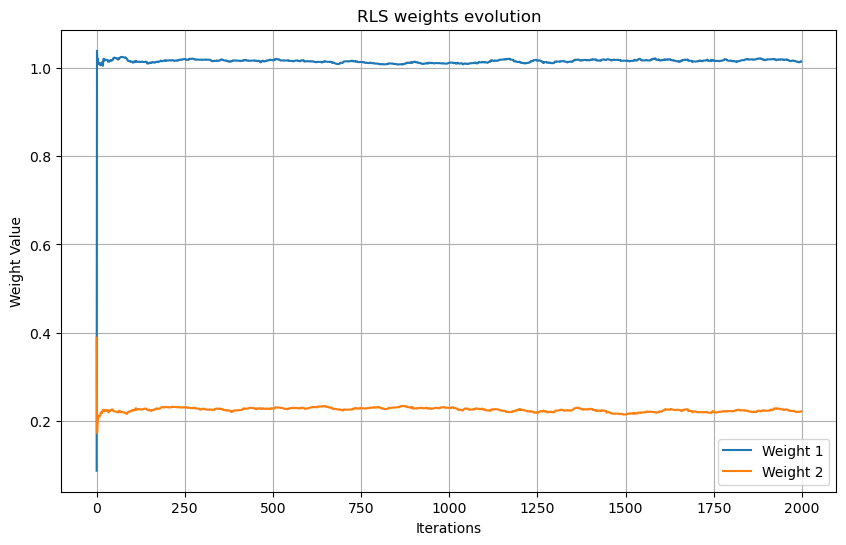

In [14]:
plot_weights_evolution(weight_evolution_rls, title="RLS weights evolution")

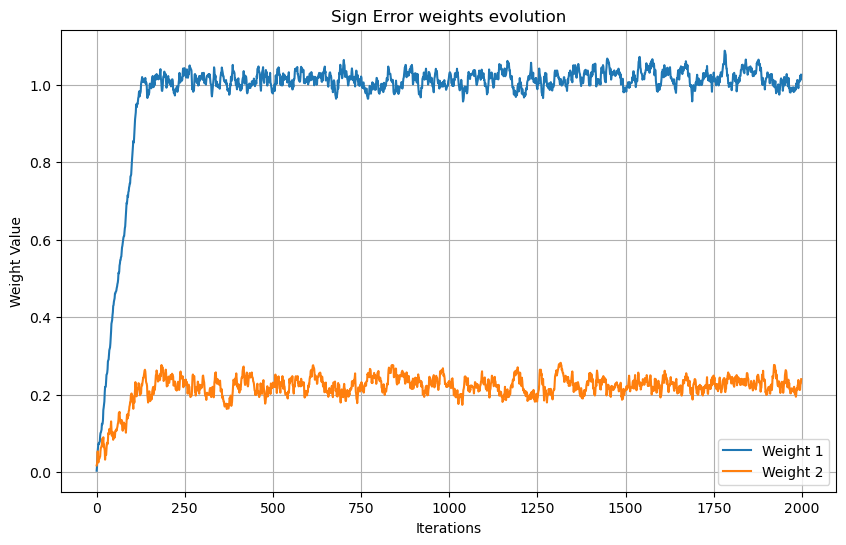

In [15]:
plot_weights_evolution(weight_evolution_sign, title="Sign Error weights evolution")

##### O Algoritimo $LMS$ (Last Means Square) apresentou uma convergência gradual e mais estável do que se comparada à convergência do RLS e com o Sinal do Erro. O ajuste dos pesos para o caso do $LMS$ depende diretamente do tamanho do passo $\mu_{LMS}$. Um valor de $\mu_{LMS}$ muito elevado pode acelerar a convergência, porém aumenta as chances de haver instabilidades no modelo. O algoritmo do sinal de Erro apresentou uma convergência mais lenta e menos precisa que o sinal $LMS$, pois utiliza apenas o sinal do erro como referência e ajuste e, assim como no $LMS$, o tamanho do passo também influencia na estabilidade e velocidade da convergência. Para o algoritmo $RLS$ a convergência ocorreu mais rapidamente que os demais algoritmos e os pesos se ajustaram quase que imediatamente às mudanças do sistema ou ao ruído. Os valores do fator de esquecimento próximo à um impõem mais pesos às amostras passadas, dessa forma, é possível realizar um ajuste fino a partir destes parâmetros para se obter uma filtragem com mais velocidade e estabilidade.

##### e) Reproduzindo os experimentos para o novo conjunto de dados, temos:

In [34]:
data = scipy.io.loadmat("dados_identificacao_ruido_impulsivo.mat")
x_2 = data["x"][0]                                # amostras do processo de entrda x(n)
d_2 = data["d"][0]                                # observações da saída do sistema

In [35]:
r_2 = autocorrelation_matrix(x_2, 1)
p_2 = compute_cross_correlation(x_2, d_2, 2)
w_2 = np.dot(np.linalg.inv(r_2), p_2.T)

##### Matriz de Autocorrelação:
$$
R_x = \begin{bmatrix}
0.9857 & 0.0185 \\
0.0185 & 0.9857 \\
\end{bmatrix}
$$

##### Vetor de Correlação Cruzada:
$$
p = \begin{bmatrix}
0.9890 & 0.2108 \\
\end{bmatrix}
$$

##### Coeficientes de Wiener:
$$
\omega = \begin{bmatrix}
0.9997 & 0.1951 \\
\end{bmatrix}
$$

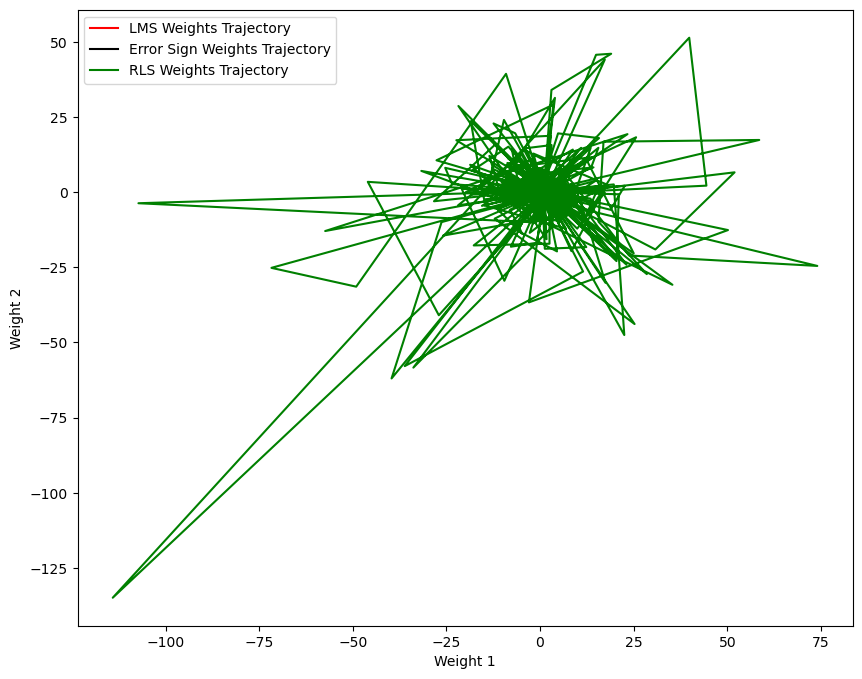

([0.0,
  -0.0019142887096821146,
  -0.004080719610180174,
  0.030502701903845367,
  -0.020429386969973203,
  0.1492176535065607,
  -0.14956784032874246,
  -0.06306357878419208,
  0.11757179463732867,
  0.06018964583834461,
  -6.281484003988489e-05,
  -0.21847282237295798,
  -0.03355426050582781,
  -0.11617439425622202,
  -0.07276234065578184,
  -0.13876883098292886,
  0.08722977752631422,
  0.19643848319446477,
  -0.0520301272813475,
  0.1115151695260891,
  0.15764256181142328,
  0.030837514393396822,
  -0.05733609117091874,
  -0.11828947279717818,
  -0.2571347511664894,
  -0.08354532519520345,
  0.029941397769675242,
  -0.0389385356513354,
  0.04565300073489578,
  0.018544383899618086,
  0.15184686260578115,
  -0.11921207712658723,
  -0.04948063276971608,
  0.05213444463270238,
  -0.07881488500010278,
  0.052853966845305175,
  -0.4055681467711492,
  0.07446475765004198,
  0.01752519480937527,
  -0.1486165471483,
  -0.12399114907388109,
  -0.04024616500740554,
  -0.46808680046175516,
 

In [47]:
generate_path_trajectory(x_2, p_2, r_2, 0.012, 0.01, 0.02, w_2, d_2)

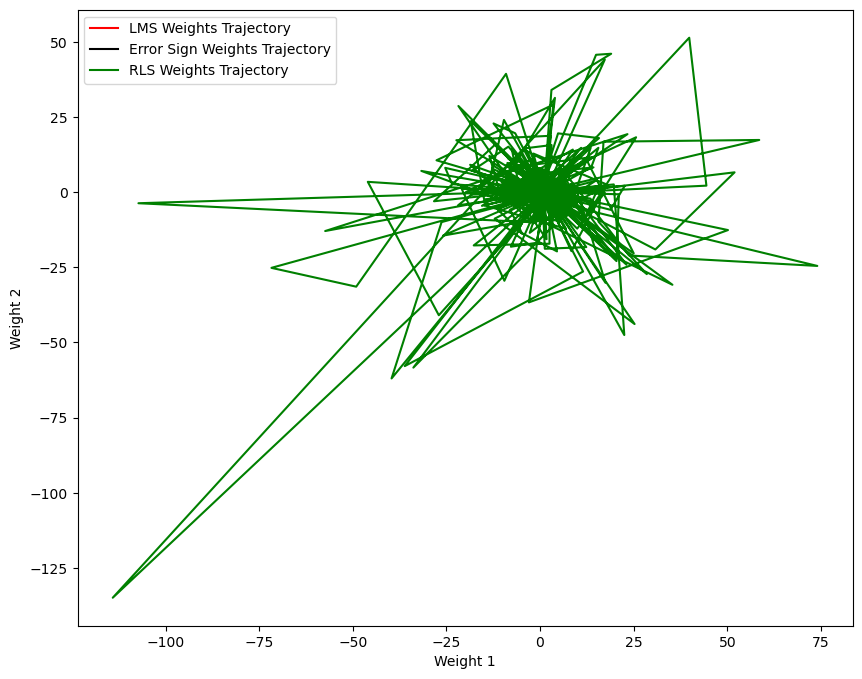

([0.0,
  -0.0015952405914017621,
  -0.0034004728107019017,
  0.025421881505222156,
  -0.017082041444345945,
  0.12466116455045677,
  -0.12544876024102514,
  -0.05268391406137029,
  0.09891109666379196,
  0.050307970443053004,
  -0.0003111307096760442,
  -0.1837083082766188,
  -0.027749329556167848,
  -0.09761363527921448,
  -0.06095237361239198,
  -0.11673870646537629,
  0.07383754942641313,
  0.16548017355391753,
  -0.04432884451589128,
  0.09432905450661037,
  0.13291315444500043,
  0.025761078561193935,
  -0.04853462556072371,
  -0.09990534021026977,
  -0.21728913539604003,
  -0.07039877649729857,
  0.025446303500053565,
  -0.033043114163569004,
  0.038741927356141896,
  0.015612360422390156,
  0.12872698268356814,
  -0.10146116977320094,
  -0.04161045482256748,
  0.04430346118276841,
  -0.06702252908312828,
  0.045074827417352616,
  -0.3444243467956564,
  0.06466368094514252,
  0.01660271666766422,
  -0.12404852482026124,
  -0.1050041854562511,
  -0.03543758183420797,
  -0.39810615

In [37]:
generate_path_trajectory(x_2, p_2, r_2, 0.01, 0.1, 0.02, w_2, d_2)

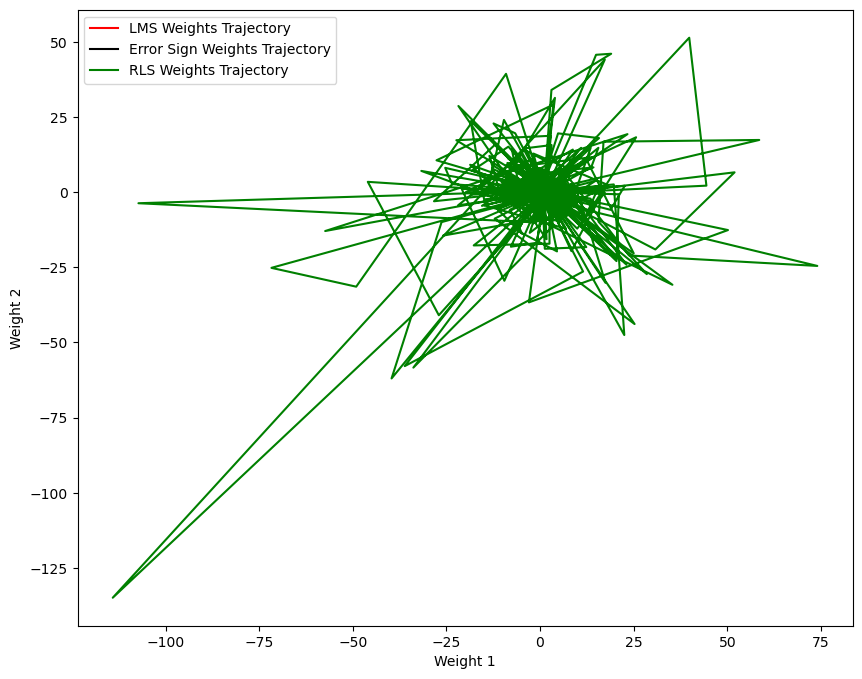

([0.0,
  -0.0015952405914017621,
  -0.0034004728107019017,
  0.025421881505222156,
  -0.017082041444345945,
  0.12466116455045677,
  -0.12544876024102514,
  -0.05268391406137029,
  0.09891109666379196,
  0.050307970443053004,
  -0.0003111307096760442,
  -0.1837083082766188,
  -0.027749329556167848,
  -0.09761363527921448,
  -0.06095237361239198,
  -0.11673870646537629,
  0.07383754942641313,
  0.16548017355391753,
  -0.04432884451589128,
  0.09432905450661037,
  0.13291315444500043,
  0.025761078561193935,
  -0.04853462556072371,
  -0.09990534021026977,
  -0.21728913539604003,
  -0.07039877649729857,
  0.025446303500053565,
  -0.033043114163569004,
  0.038741927356141896,
  0.015612360422390156,
  0.12872698268356814,
  -0.10146116977320094,
  -0.04161045482256748,
  0.04430346118276841,
  -0.06702252908312828,
  0.045074827417352616,
  -0.3444243467956564,
  0.06466368094514252,
  0.01660271666766422,
  -0.12404852482026124,
  -0.1050041854562511,
  -0.03543758183420797,
  -0.39810615

In [38]:
generate_path_trajectory(x_2, p_2, r_2, 0.01, 0.1, 0.02, w_2, d_2)

In [39]:
r_n = autocorrelation_matrix(x_2, 199)
p_n = compute_cross_correlation(x_2, d_2, 200)
w_n = np.dot(np.linalg.inv(r_n), p_n.T)

In [54]:
def get_trajectory_ndim_LMS(x, d, mu_LMS, mu_sign, lambda_RLS, true_w):
    np.random.seed(0)
    T = len(x)  # Number of samples
    n = len(true_w)  # Number of weights (filter length)
    w_LMS = np.zeros((T, n))
    w_sign = np.zeros((T, n))
    w_RLS = np.zeros((T, n))
    P = np.eye(n) * 1000  # Initial inverse correlation matrix for RLS
    X = np.zeros((T, n))
    for t in range(n, T):
        X[t] = x[t-n:t][::-1]  # Use the last n samples, reversed for filter alignment

    W1, W2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    fixed_weights = true_w[2:]  # Fix weights w2, w3, ..., wn at their true values
    EQM = np.mean([
        (d[t] - (W1 * X[t, 0] + W2 * X[t, 1] + np.dot(fixed_weights, X[t, 2:]))) ** 2
        for t in range(n, T)
    ], axis=0)

    for t in range(n, T):
        x_n = X[t]  # Input vector at time t

        # LMS
        y_LMS = np.dot(w_LMS[t - 1], x_n)
        e_LMS = d[t] - y_LMS
        w_LMS[t] = w_LMS[t - 1] + mu_LMS * e_LMS * x_n

        # Sign Error
        y_sign = np.dot(w_sign[t - 1], x_n)
        e_sign = d[t] - y_sign
        w_sign[t] = w_sign[t - 1] + mu_sign * np.sign(e_sign) * x_n

        # RLS
        y_RLS = np.dot(w_RLS[t - 1], x_n)
        e_RLS = d[t] - y_RLS
        k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
        w_RLS[t] = w_RLS[t - 1] + k * e_RLS
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS

    # Plot trajectories for the first two weights (w0 and w1)
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contour(W1, W2, EQM, levels=20, cmap="viridis")
    ax.plot(w_LMS[n:, 0], w_LMS[n:, 1], 'r-', label="lms trajectory")
    # ax.plot(w_sign[n:, 0], w_sign[n:, 1], 'b-', label="Sign Error Trajectory")
    # ax.plot(w_RLS[n:, 0], w_RLS[n:, 1], 'g-', label="RLS Trajectory")
    ax.plot(true_w[0], true_w[1], 'kx', label="wiener solution", markersize=10, markeredgewidth=2)
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    ax.legend()
    plt.show()

def get_trajectory_ndim_RLS(x, d, mu_LMS, mu_sign, lambda_RLS, true_w):
    np.random.seed(0)
    T = len(x)  # Number of samples
    n = len(true_w)  # Number of weights (filter length)
    w_LMS = np.zeros((T, n))
    w_sign = np.zeros((T, n))
    w_RLS = np.zeros((T, n))
    P = np.eye(n) * 1000  # Initial inverse correlation matrix for RLS
    X = np.zeros((T, n))
    for t in range(n, T):
        X[t] = x[t-n:t][::-1]  # Use the last n samples, reversed for filter alignment

    W1, W2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    fixed_weights = true_w[2:]  # Fix weights w2, w3, ..., wn at their true values
    EQM = np.mean([
        (d[t] - (W1 * X[t, 0] + W2 * X[t, 1] + np.dot(fixed_weights, X[t, 2:]))) ** 2
        for t in range(n, T)
    ], axis=0)

    for t in range(n, T):
        x_n = X[t]  # Input vector at time t

        # LMS
        y_LMS = np.dot(w_LMS[t - 1], x_n)
        e_LMS = d[t] - y_LMS
        w_LMS[t] = w_LMS[t - 1] + mu_LMS * e_LMS * x_n

        # Sign Error
        y_sign = np.dot(w_sign[t - 1], x_n)
        e_sign = d[t] - y_sign
        w_sign[t] = w_sign[t - 1] + mu_sign * np.sign(e_sign) * x_n

        # RLS
        y_RLS = np.dot(w_RLS[t - 1], x_n)
        e_RLS = d[t] - y_RLS
        k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
        w_RLS[t] = w_RLS[t - 1] + k * e_RLS
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS

    # Plot trajectories for the first two weights (w0 and w1)
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contour(W1, W2, EQM, levels=20, cmap="viridis")
    # ax.plot(w_LMS[n:, 0], w_LMS[n:, 1], 'r-', label="LMS Trajectory")
    # ax.plot(w_sign[n:, 0], w_sign[n:, 1], 'b-', label="Sign Error Trajectory")
    ax.plot(w_RLS[n:, 0], w_RLS[n:, 1], 'g-', label="rls coefficients evolution")
    ax.plot(true_w[0], true_w[1], 'kx', label="wiener solution", markersize=10, markeredgewidth=2)
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    ax.legend()
    plt.show()

def get_trajectory_ndim_errsig(x, d, mu_LMS, mu_sign, lambda_RLS, true_w):
    np.random.seed(0)
    T = len(x)  # Number of samples
    n = len(true_w)  # Number of weights (filter length)
    w_LMS = np.zeros((T, n))
    w_sign = np.zeros((T, n))
    w_RLS = np.zeros((T, n))
    P = np.eye(n) * 1000  # Initial inverse correlation matrix for RLS
    X = np.zeros((T, n))
    for t in range(n, T):
        X[t] = x[t-n:t][::-1]  # Use the last n samples, reversed for filter alignment

    W1, W2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    fixed_weights = true_w[2:]  # Fix weights w2, w3, ..., wn at their true values
    EQM = np.mean([
        (d[t] - (W1 * X[t, 0] + W2 * X[t, 1] + np.dot(fixed_weights, X[t, 2:]))) ** 2
        for t in range(n, T)
    ], axis=0)

    for t in range(n, T):
        x_n = X[t]  # Input vector at time t

        # LMS
        y_LMS = np.dot(w_LMS[t - 1], x_n)
        e_LMS = d[t] - y_LMS
        w_LMS[t] = w_LMS[t - 1] + mu_LMS * e_LMS * x_n

        # Sign Error
        y_sign = np.dot(w_sign[t - 1], x_n)
        e_sign = d[t] - y_sign
        w_sign[t] = w_sign[t - 1] + mu_sign * np.sign(e_sign) * x_n

        # RLS
        y_RLS = np.dot(w_RLS[t - 1], x_n)
        e_RLS = d[t] - y_RLS
        k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
        w_RLS[t] = w_RLS[t - 1] + k * e_RLS
        P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS

    # Plot trajectories for the first two weights (w0 and w1)
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contour(W1, W2, EQM, levels=20, cmap="viridis")
    # ax.plot(w_LMS[n:, 0], w_LMS[n:, 1], 'r-', label="LMS Trajectory")
    ax.plot(w_sign[n:, 0], w_sign[n:, 1], 'bo', label="sign error coefficients evolution")
    # ax.plot(w_RLS[n:, 0], w_RLS[n:, 1], 'g-', label="RLS Trajectory")
    ax.plot(true_w[0], true_w[1], 'kx', label="wiener solution", markersize=10, markeredgewidth=2)
    ax.set_xlabel("Weight 1")
    ax.set_ylabel("Weight 2")
    ax.legend()
    plt.show()


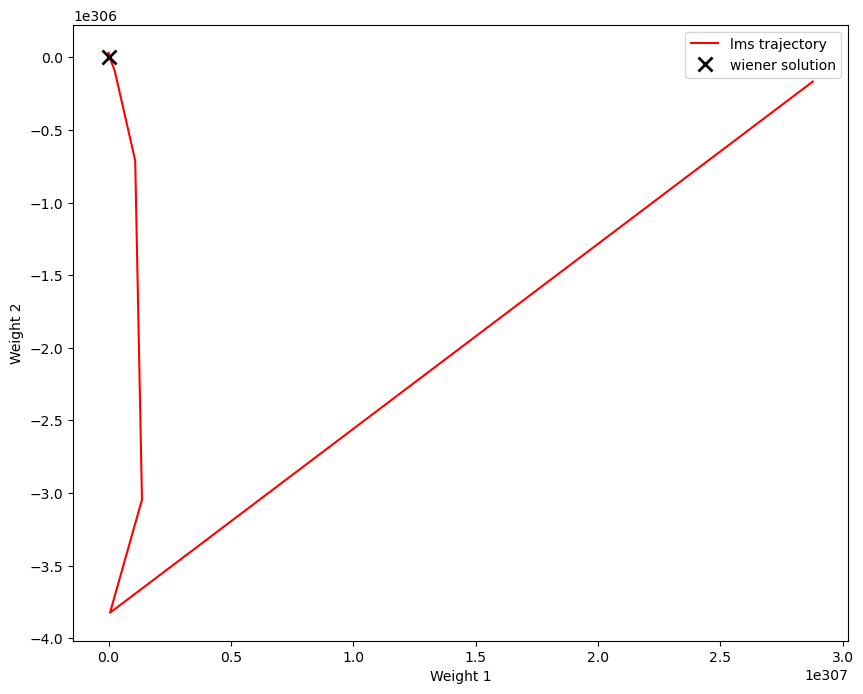

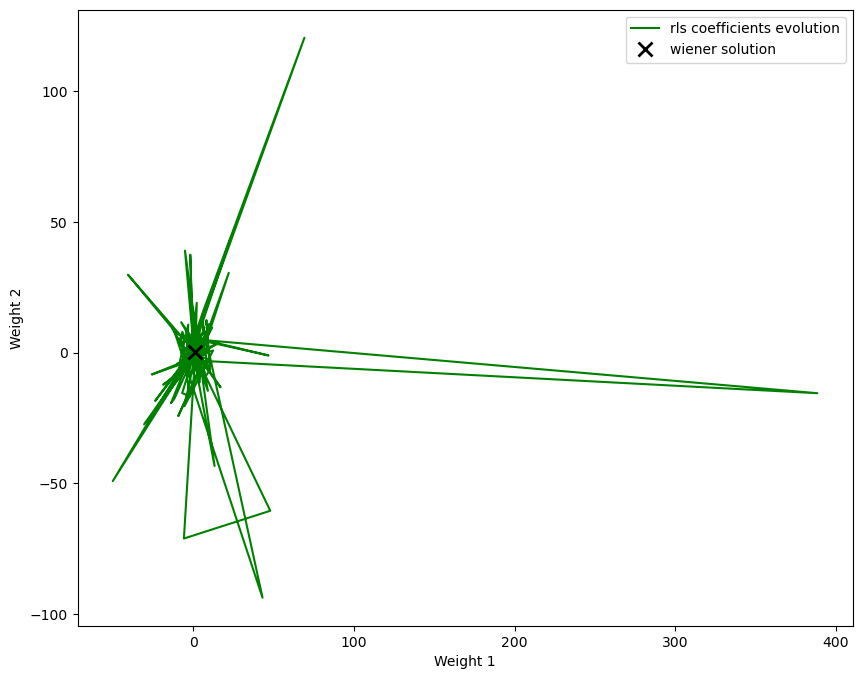

ValueError: 'black dot' is not a valid format string (unrecognized character 'l')

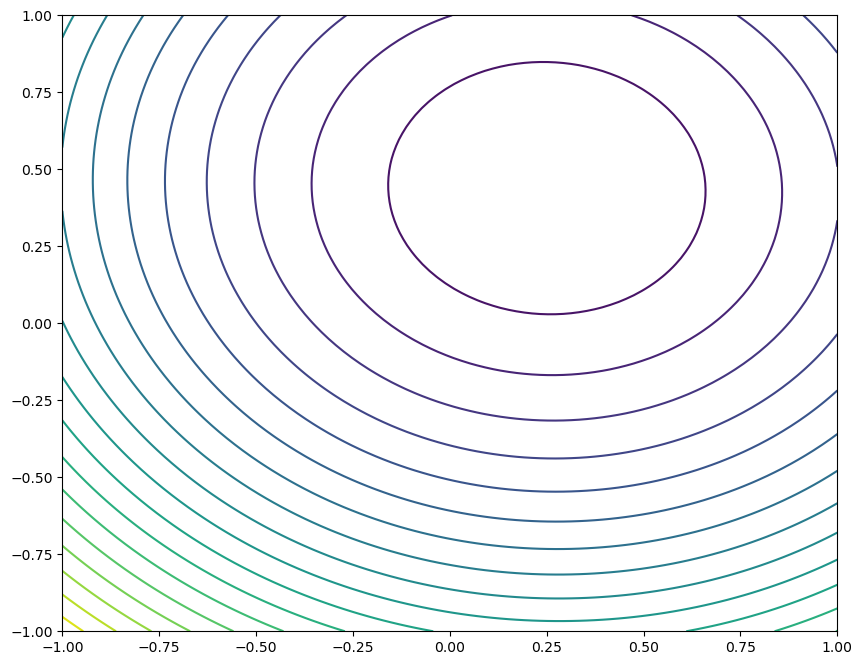

In [55]:
get_trajectory_ndim_LMS(x_2, d_2, 0.15, 0.1, 0.9, w_n)
get_trajectory_ndim_RLS(x_2, d_2, 0.01, 0.01, 0.2, w_n)
get_trajectory_ndim_errsig(x_2, d_2, 0.05, 0.05, 0.9, w_n)


In [32]:
# for i in np.arange(0.1, 1., 0.1):
#     for n in np.arange(1, 0.1, -0.1):
#         print("mu_lms", i)
#         print("lambda_RLS", n)
#         get_trajectory_ndim_LMS(x_2, d_2, round(i,2), 0.1, round(n,2), w_n)
#         # get_trajectory_ndim_RLS(x_2, d_2, round(i,2), 0.01, round(n,2), w_n)
#         get_trajectory_ndim_errsig(x_2, d_2, round(i,2), 0.05, round(n,2), w_n)

In [42]:
data = scipy.io.loadmat("dados_identificacao_ruido_impulsivo.mat")
x_2 = data["x"][0]                                # amostras do processo de entrda x(n)
d_2 = data["d"][0]                                # observações da saída do sistema
data = scipy.io.loadmat("dados_identificacao_ruido_gaussiano.mat")
x_1 = data["x"][0]                                # amostras do processo de entrda x(n)
d_1 = data["d"][0]                                # observações da saída do sistema

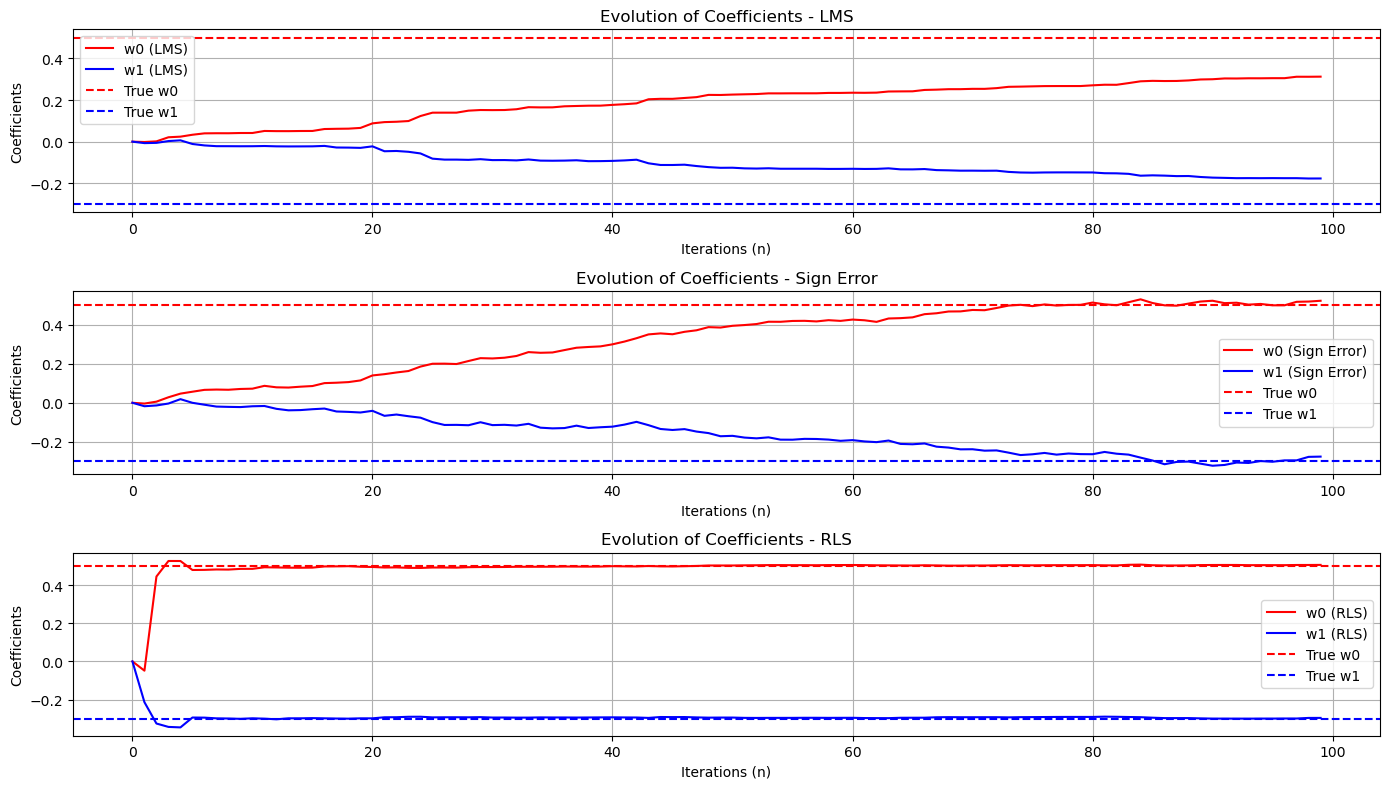

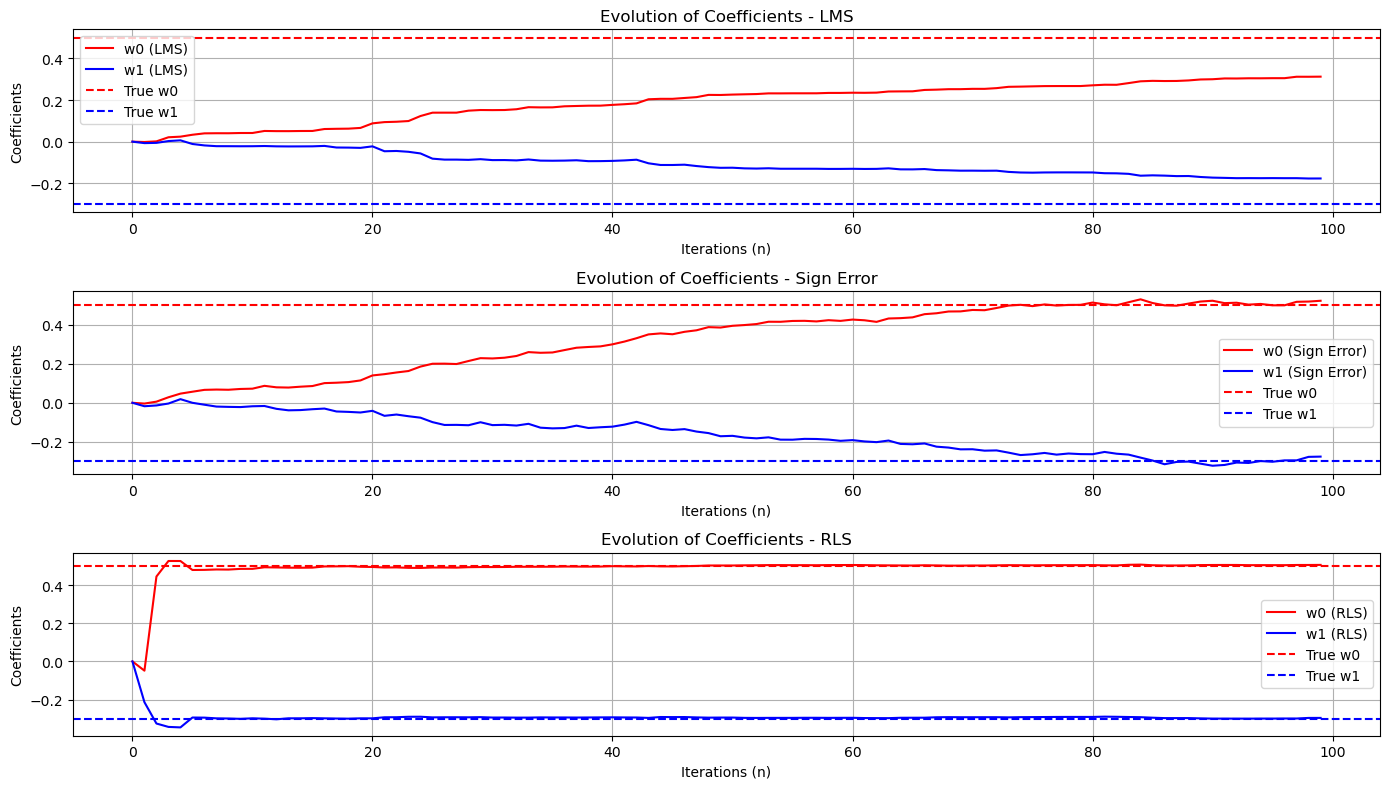

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters and setup
np.random.seed(0)
T = 100  # Number of samples
mu_LMS = 0.01  # Step size for LMS
mu_sign = 0.01  # Step size for Sign Error
lambda_RLS = 0.99  # Forgetting factor for RLS

# Input signal and unknown system
x = np.random.randn(T)  # Gaussian white noise
true_w = np.array([0.5, -0.3])  # True weights of the system
d = np.convolve(x, true_w, 'same') + 0.05 * np.random.randn(T)  # Noisy output

# Initialize weights and RLS matrix
w_LMS = np.zeros((T, 2))
w_sign = np.zeros((T, 2))
w_RLS = np.zeros((T, 2))
P = np.eye(2) * 1000

# Compute filter coefficients
for n in range(1, T):
    x_n = np.array([x[n], x[n - 1]])  # Input vector

    # LMS
    y_LMS = np.dot(w_LMS[n-1], x_n)
    e_LMS = d[n] - y_LMS
    w_LMS[n] = w_LMS[n-1] + mu_LMS * e_LMS * x_n

    # Sign Error
    y_sign = np.dot(w_sign[n-1], x_n)
    e_sign = d[n] - y_sign
    w_sign[n] = w_sign[n-1] + mu_sign * np.sign(e_sign) * x_n

    # RLS
    y_RLS = np.dot(w_RLS[n-1], x_n)
    e_RLS = d[n] - y_RLS
    k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
    w_RLS[n] = w_RLS[n-1] + k * e_RLS
    P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS

# Plot the evolution of filter coefficients
plt.figure(figsize=(14, 8))

# LMS
plt.subplot(3, 1, 1)
plt.plot(w_LMS[:, 0], label="w0 (LMS)", color="red")
plt.plot(w_LMS[:, 1], label="w1 (LMS)", color="blue")
plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
plt.title("Evolution of Coefficients - LMS")
plt.xlabel("Iterations (n)")
plt.ylabel("Coefficients")
plt.legend()
plt.grid()

# Sign Error
plt.subplot(3, 1, 2)
plt.plot(w_sign[:, 0], label="w0 (Sign Error)", color="red")
plt.plot(w_sign[:, 1], label="w1 (Sign Error)", color="blue")
plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
plt.title("Evolution of Coefficients - Sign Error")
plt.xlabel("Iterations (n)")
plt.ylabel("Coefficients")
plt.legend()
plt.grid()

# RLS
plt.subplot(3, 1, 3)
plt.plot(w_RLS[:, 0], label="w0 (RLS)", color="red")
plt.plot(w_RLS[:, 1], label="w1 (RLS)", color="blue")
plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
plt.title("Evolution of Coefficients - RLS")
plt.xlabel("Iterations (n)")
plt.ylabel("Coefficients")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# Parameters and setup
np.random.seed(0)
T = 100  # Number of samples
mu_LMS = 0.01  # Step size for LMS
mu_sign = 0.01  # Step size for Sign Error
lambda_RLS = 0.99  # Forgetting factor for RLS

# Input signal and unknown system
x = np.random.randn(T)  # Gaussian white noise
true_w = np.array([0.5, -0.3])  # True weights of the system
d = np.convolve(x, true_w, 'same') + 0.05 * np.random.randn(T)  # Noisy output

# Initialize weights and RLS matrix
w_LMS = np.zeros((T, 2))
w_sign = np.zeros((T, 2))
w_RLS = np.zeros((T, 2))
P = np.eye(2) * 1000

# Compute filter coefficients
for n in range(1, T):
    x_n = np.array([x[n], x[n - 1]])  # Input vector

    # LMS
    y_LMS = np.dot(w_LMS[n-1], x_n)
    e_LMS = d[n] - y_LMS
    w_LMS[n] = w_LMS[n-1] + mu_LMS * e_LMS * x_n

    # Sign Error
    y_sign = np.dot(w_sign[n-1], x_n)
    e_sign = d[n] - y_sign
    w_sign[n] = w_sign[n-1] + mu_sign * np.sign(e_sign) * x_n

    # RLS
    y_RLS = np.dot(w_RLS[n-1], x_n)
    e_RLS = d[n] - y_RLS
    k = np.dot(P, x_n) / (lambda_RLS + np.dot(x_n, np.dot(P, x_n)))
    w_RLS[n] = w_RLS[n-1] + k * e_RLS
    P = (P - np.outer(k, np.dot(x_n, P))) / lambda_RLS

# Plot the evolution of filter coefficients
plt.figure(figsize=(14, 8))

# LMS
plt.subplot(3, 1, 1)
plt.plot(w_LMS[:, 0], label="w0 (LMS)", color="red")
plt.plot(w_LMS[:, 1], label="w1 (LMS)", color="blue")
plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
plt.title("Evolution of Coefficients - LMS")
plt.xlabel("Iterations (n)")
plt.ylabel("Coefficients")
plt.legend()
plt.grid()

# Sign Error
plt.subplot(3, 1, 2)
plt.plot(w_sign[:, 0], label="w0 (Sign Error)", color="red")
plt.plot(w_sign[:, 1], label="w1 (Sign Error)", color="blue")
plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
plt.title("Evolution of Coefficients - Sign Error")
plt.xlabel("Iterations (n)")
plt.ylabel("Coefficients")
plt.legend()
plt.grid()

# RLS
plt.subplot(3, 1, 3)
plt.plot(w_RLS[:, 0], label="w0 (RLS)", color="red")
plt.plot(w_RLS[:, 1], label="w1 (RLS)", color="blue")
plt.axhline(true_w[0], color="red", linestyle="--", label="True w0")
plt.axhline(true_w[1], color="blue", linestyle="--", label="True w1")
plt.title("Evolution of Coefficients - RLS")
plt.xlabel("Iterations (n)")
plt.ylabel("Coefficients")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()